# Image processing on brain medical images

This notebook treats about medical image processing with contrast enhancement and automatic segmentation on brain medical images. We will explore different kind of segmentations, algorithms and medical images.

First, we will explore contrast enhancement in Magnetic Resonance (MR) images with different techniques.

Second, based on MR images, we will segment the white matter, grey matter and cerebrospinal fluid of the brain. Different algorithms will be tested for that task.

Third, we will segment the corpus callosum (CC) and the corticospinal tract (CT) . This segmentation will be based on the diffuse tensor imaging (DTI). 

Forth, we will use the brain of an alcoholic patient to observe how CC and CT segmentation algorithm adapt to such brain. In an alcoholic patient brain, the CC become really small and harder to segment.

## Imports

In [77]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage.morphology import binary_fill_holes
from scipy.stats import norm as normal
from skimage.io import imread
from skimage.color import rgb2grey
from IPython import display
import math as m
import random
import matplotlib.patches as mpatches
from scipy.ndimage import morphology
import copy
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from sklearn.cluster import KMeans



## Loading of the medical images

In the first part of this notebook, we will segment the white matter, grey matter and cerebrospinal fluid of the brain. It will be done on MR images. Before starting to segment our images, we need some preprocessing.

First, we need to transform the DICOM files into a single NIFTI file. Thanks to Nicolas Delinte, we have used the program dcm2niix.exe which convert DICOM file into NIFTI file automatically.

Second, since the skull may disturb our segmentation algorithms, we have performed a skull stripping on the image using the command BET from FSL (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide). We load here both the original MR image with the skull and the skullstripped image.

In [2]:
#DICOM to NIFTI conversion

#!dcm2niix -h
#!dcm2niix Brain_T1_scan_Patient1

In [3]:
#original MR image
file_path = "Data/Brain_T1.nii"
#skullstripped image
file_path_mask= "Data/BrainMask.nii.gz"
img=nib.load(file_path)
img_mask = nib.load(file_path_mask)
data=img.get_fdata()
mask_data = img_mask.get_fdata()


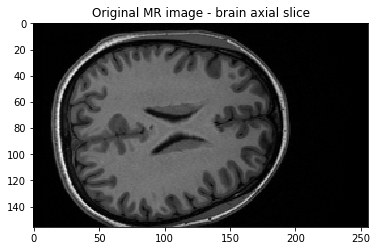

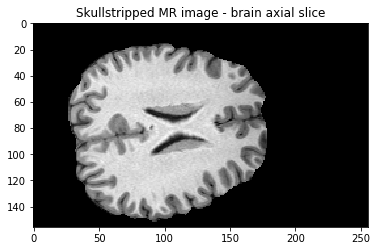

In [4]:
plt.imshow(data[:,:,190], cmap='gray')
plt.title('Original MR image - brain axial slice')
plt.show()
plt.imshow(mask_data[:,:,190], cmap='gray')
plt.title('Skullstripped MR image - brain axial slice')
plt.show()

## Contrast enhancement

Contrast enhancement is used in medical imaging to help physicits to better differentiate different parts in an image.
One common method is called histogram equalization. Its goal is to have a linear cumulative distribution function (cdf) across the range of intensity to have a better use of all possible intensities.  In a typical grey image, the intensity is coded on 8 bits giving a range from 0 to 255.

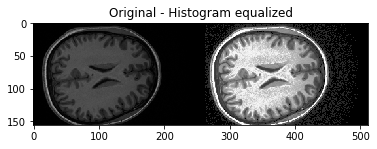

In [7]:
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html

grey_im = (data*(255/data.max())).astype(np.uint8)

img = grey_im[:,:,190]
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side

plt.imshow(res, cmap='gray')
plt.title('Original - Histogram equalized')
plt.show()

Own implementation

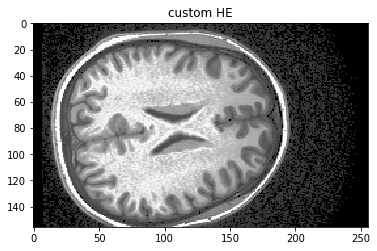

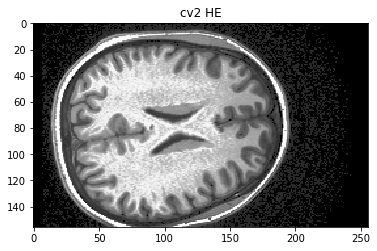

In [8]:
def hist_equalizer(img):
    
    result = np.zeros(img.shape).astype(np.uint8)
    
    #Set the range of intensity of the image between 0 and 255 and as unsigned integers
    grey_im = (img*(255/img.max())).astype(np.uint8)
    
    #Create the histogram
    #We got up to 256 because the last bin is [255,256] while all the others are [n-1,n[
    #meaning that the last bin would have sum the pixels with value 254 and 255 if we had stop at 255
    counts, bins = np.histogram(grey_im.flatten(),256, [0,256])
    
    #Create the cdf
    cdf = counts.cumsum()
    cdf_min = cdf[np.nonzero(cdf)[0][0]] #first element that is not zero
    
    i_max, j_max = img.shape
    
    for i in range(i_max):
        for j in range(j_max):
            #value in the original image to be transformed
            val = grey_im[i][j]

            #we just take the normalized cdf of the value by the inverse distribution 
            #function (quantile function) multiply it by 255 (the max range) and round the result
            result[i][j] = m.floor((cdf[val] - cdf_min)/(i_max*j_max - cdf_min)*(256-1))

    return result

custom_res = hist_equalizer(data[:,:,190])

plt.imshow(custom_res,cmap='gray')
plt.title("custom HE")
plt.show()

plt.imshow(equ,cmap='gray')
plt.title("cv2 HE")
plt.show()

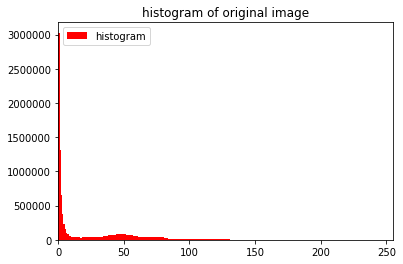

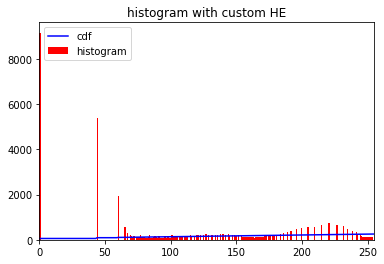

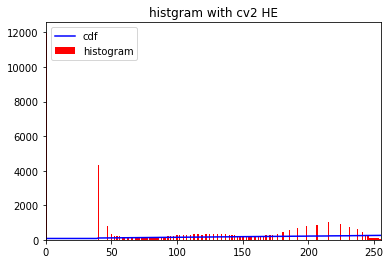

In [10]:
#Comparing histogram of custom and cv2 histogram equalizer with the original one


#original
hists, bins = np.histogram(grey_im, 256)
cdf = hists.cumsum()
cdf_original = cdf * 255/ cdf.max()

plt.hist(grey_im.flatten(), 256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('histogram',), loc = 'upper left')
plt.title("histogram of original image")
plt.show()

#custom
hists, bins = np.histogram(custom_res, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(custom_res.flatten(), 256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("histogram with custom HE")
plt.show()

#cv2
hists, bins = np.histogram(equ, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("histgram with cv2 HE")
plt.show()

We can see that on the histogram of the original image, the majority of intensity values are below 130 meaning that approximatively half of the range of intensity isn't fully used. For both histogram equalizer, the full range is used with few differences. The only downside of HE is that black pixels from the background have been enhanced leading to clearer pixel in it that could be classified as noise.
A solution is to use contrast-limited adaptive histogram equalization (CLAHE). It consists of dividing the image into tiles and apply the equalization locally such that dark regions stay dark and we only enhance edges. This method is sensitive to noise in near constant value because it would have to distribute the pixel between the local range of intensities. To avoid this, a threshold (clipLimit) is added to limit the contrast amplification in each region.

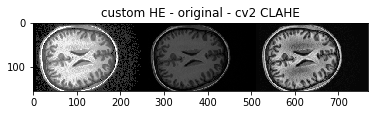

In [11]:
img = grey_im[:,:,190]
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8)) #grid of 8 by 8
cl1 = clahe.apply(img)
res = np.hstack((custom_res,img,cl1))
plt.imshow(res, cmap='gray')
plt.title('custom HE - original - cv2 CLAHE')
plt.show()

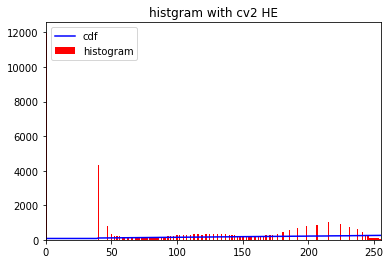

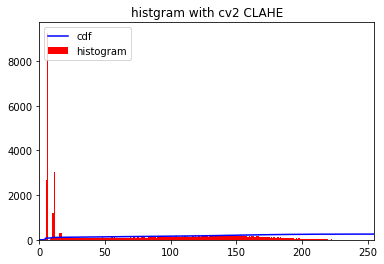

maximum value of CLAHE: 241


In [12]:
hists, bins = np.histogram(equ, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("histgram with cv2 HE")
plt.show()

hists, bins = np.histogram(cl1, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(cl1.flatten(),256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("histgram with cv2 CLAHE")
plt.show()

print("maximum value of CLAHE: " + str(cl1.max()))

As shown above, the salt noise in dark areas is no more. But the trade-off is that, when comparing the histograms of HE and CLAHE, CLAHE does not cover the whole range of intensity anymore. This is due to the threshold. A clipLimit of 5 gives good results to remove salt noise, but by increasing its value up to 16 for example, the whole range is covered again but salt noise can be seen too.

## Segmentation white and grey matter + cerebrospinal fluid

Before presenting the different segmentation techniques used in the work, we define some functions that will be used through the segmentation algorithms and the result visualization.

In [13]:
## Usefull functions cell 
  
def getForegroundMask(originalBrainImg, backGroundValue=0):
    # Get a binary mask from an array, where the pixels > 0 are set to 1
    foregroundMask = originalBrainImg > backGroundValue
    return binary_fill_holes(foregroundMask)

def getForegroundArray(originalBrainImg, foregroundMask):
    # Return a 1D array with the pixels from originalBrainImg which are under the foregroundmask
    return originalBrainImg[foregroundMask==1]
 
def plotHistogramWithDistribs(array, meansArray, stdsArray):
    # Plot the histogram of an array and gaussian distributions corresponding to meansArray / stdsArray
    plt.figure(figsize=(10, 10))
    hist, bin_edges = np.histogram(array, bins=255, normed=True)
    plt.bar(bin_edges[:-1], hist, align='center', width=0.005)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Intensity')
    x = np.linspace(0, 1, 255)
    for (mean, std) in zip(meansArray, stdsArray):
        plt.plot(x, normal.pdf(x, mean, std), linewidth=1)
        
def plotHistogramWithTresholds(array, tresh):
    # Plot the histogram of an array and gaussian distributions corresponding to meansArray / stdsArray
    plt.figure(figsize=(10, 10))
    hist, bin_edges = np.histogram(array, bins=255, normed=True)
    plt.bar(bin_edges[:-1], hist, align='center', width=0.005)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Intensity')
    x = np.linspace(0, 1, 255)
    for i in tresh:
        plt.axvline(x = i,color = 'red')

    

We have decided to rescale our pixel intensities between 0 and 1. By doing so, we obtain generic algorithms that can be used on every brain MR image as long it is rescaled between 0 and 1.

In [14]:

## Read and rescale image between 0 and 1 
originalBrainImg = mask_data

originalBrainImg = originalBrainImg / np.max(originalBrainImg)

## Get only non zeros pixels from the image (Use functions from previous cell)
ZeroBrainImg = getForegroundArray(originalBrainImg,getForegroundMask(originalBrainImg,0))

We will explore 3 different segmentation techniques for our task : The Otsu method, Exceptation-Maximization algorithm and K-means algorithm.

 ### Otsu method

The Otsu method consist in fixing manually hard treshold for the segmentation.

In [15]:
def OtsuSeg(BrainImg, tresh):
    SegmentedBrain = np.zeros(BrainImg.shape)
    for i in range(BrainImg.shape[0]):
        for j in range(BrainImg.shape[1]):
            for z in range(BrainImg.shape[2]):
                if BrainImg[i,j,z] > 0 and BrainImg[i,j,z] <= tresh[0] :
                    SegmentedBrain[i,j,z] = 1/3
                elif BrainImg[i,j,z] > tresh[0] and BrainImg[i,j,z] <= tresh[1] :
                    SegmentedBrain[i,j,z] = 2/3
                elif BrainImg[i,j,z] > tresh[1]:
                    SegmentedBrain[i,j,z] = 1
    return SegmentedBrain

            

C:\Users\MediMonster\anaconda3\lib\site-packages\ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


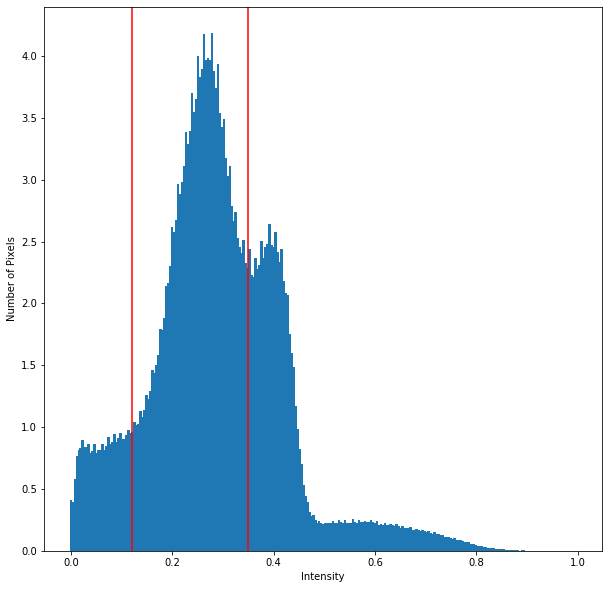

In [16]:
tresh = [0.12,0.35]
plotHistogramWithTresholds(ZeroBrainImg,tresh)
OtsuBrain = OtsuSeg(originalBrainImg,tresh)

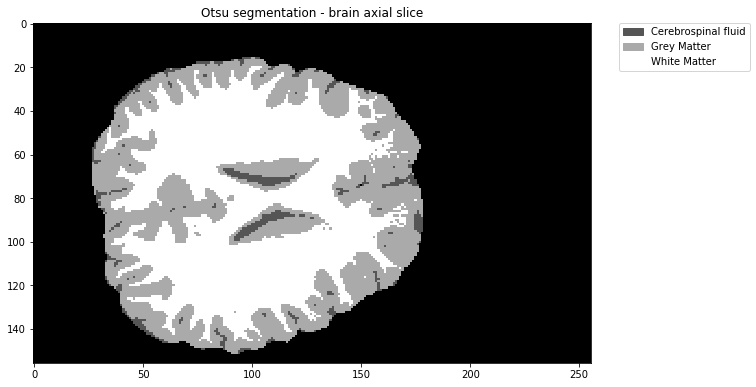

In [17]:
## Show Otsu segmentation results

values = np.unique(OtsuBrain.ravel())
values = values[1:]

plt.figure(figsize=(10,10))
im = plt.imshow(OtsuBrain[:,:,190],cmap=plt.cm.gray)

# get the colors of the values, according to the 
# colormap used by imshow

colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
labels = {0: 'Cerebrospinal fluid',1:'Grey Matter',2:'White Matter'}

patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title('Otsu segmentation - brain axial slice')
plt.show()

As observed on both the histogram and the visualization, The Otsu method gives pretty good segmentation results. However, since the tresholds are fixed manually, the method is not transposable to other images. In consequence, we need to find an other algorithm for our purpose.

### Exceptation-Maximization method 

The E-M algorithm consist in finding the voxel intensity distribution of each part of our segmentation (GM, WM, cerebrospinal fluid). It is done following an iterative process where we try to maximize probability functions. The distributions are fixed as normal distribution. The algorithm find the best mean and standard deviation for each of them.

initialMeansArray [0.1  0.25 0.4 ]
initialStdsArray [0.1 0.1 0.1]


C:\Users\MediMonster\anaconda3\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  from ipykernel import kernelapp as app


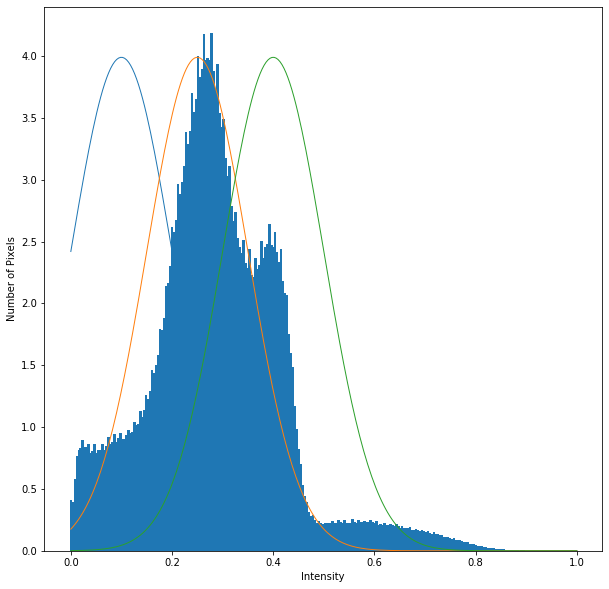

In [18]:
%matplotlib inline




## Define classes for the classification
classList = ['Cerebro','WhiteMatter', 'GreyMatter']
numberOfClasses = len(classList)

## Initial conditions (You can change them)
initialMeansArray = np.array([0.1,0.25,0.4])
initialStdsArray = np.array([0.1,0.1,0.1])
priorProbabilities = [0.33,0.33,0.33]

print('initialMeansArray', initialMeansArray)
print('initialStdsArray', initialStdsArray)
plotHistogramWithDistribs(ZeroBrainImg, initialMeansArray, initialStdsArray)

In [19]:



def em(brainArray,pixelArray, meanArray, stdArray, priorProbs, tol=1e-4, max_iter=1000):
    
    ## TO COMPLETE
    
    ## ---------------------if you want to see the optimisation steps---------------------
    colorList = ['r', 'g', 'b']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    hist, bin_edges = np.histogram(pixelArray, bins=255, normed=True)
    ax.bar(bin_edges[:-1], hist, align='center', width=0.005)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Grey Levels')
    x = np.linspace(0, 1, 255)
    ## -----------------------------------------------------------------------------------
    
    meansArray = meanArray.copy()
    stdsArray = stdArray.copy()
    mean_diff = 1
    std_diff = 1
    pixel_x = brainArray.shape[0]
    pixel_y = brainArray.shape[1]
    pixel_z = brainArray.shape[2]

    nb_set = meansArray.shape[0]
    
    uniquePixelValues,count = np.unique(pixelArray,return_counts = True)
    #pour enlever 0
    uniquePixelValues = uniquePixelValues[1:]

    count = count[1:]
    print(count)
    
    pixel_diff = uniquePixelValues.shape[0]
    print(pixel_diff)
    
    # Create empty matrix of the shape you need
    pixels_class_probs = np.zeros((pixel_diff,nb_set))
    class_prob = np.zeros((pixel_diff,nb_set))
    for i in range(nb_set):
        pixels_class_probs[:,i] = (1.0/(m.sqrt(2*m.pi)*stdsArray[i]))*np.exp(-0.5*np.square((uniquePixelValues-meansArray[i])/stdsArray[i]))

    for iterNumber in range(max_iter):
        if (mean_diff < tol and std_diff < tol):
            break
        
        print('Iteration : ', iterNumber)
        
        # Step E(xpectaction)
        for i in range(nb_set):
            class_prob[:,i] = ((pixels_class_probs[:,i])*priorProbs[i])/np.sum(pixels_class_probs*priorProbs,axis=1)    
        
        

        # Step M(aximization)
        oldMean = meansArray.copy()
        oldStd = stdsArray.copy()
        for i in range(nb_set):
            meansArray[i] = np.sum(class_prob[:,i]*count*uniquePixelValues)/np.sum(count*class_prob[:,i])
            stdsArray[i] = m.sqrt(np.sum(count*class_prob[:,i]*(uniquePixelValues-meansArray[i])**2)/np.sum(count*class_prob[:,i]))

        
        
        
        # Update prior probabilities
        for i in range(nb_set):
            pixels_class_probs[:,i] = (1.0/(m.sqrt(2*m.pi)*stdsArray[i]))*np.exp(-0.5*np.square((uniquePixelValues-meansArray[i])/stdsArray[i]))
 
        
        # Compute convergence conditions to check in next iteration
        mean_diff = max(abs(meansArray-oldMean))
        std_diff = max(abs(stdsArray-oldStd))
        
        
        
         ## ---------------------if you want to see the optimisation steps---------------------
        for elem in ax.lines:
            elem.remove()
        for i in range(meansArray.shape[0]):
            ax.plot(x, normal.pdf(x, meansArray[i], stdsArray[i]), linewidth=1, color=colorList[i])
        display.clear_output(wait=True)
        display.display(plt.gcf())
        ##-----------------------------------------------------------------------------------
        

    
    SegmentedBrain = np.zeros((pixel_x,pixel_y,pixel_z))
    for i in range(pixel_diff):
        x,y,z = np.where(brainArray == uniquePixelValues[i])
        SegmentedBrain[x,y,z] = random.choices(range(1,nb_set+1),weights = class_prob[i,:],k=len(x))

        
    return class_prob, meansArray, stdsArray, SegmentedBrain

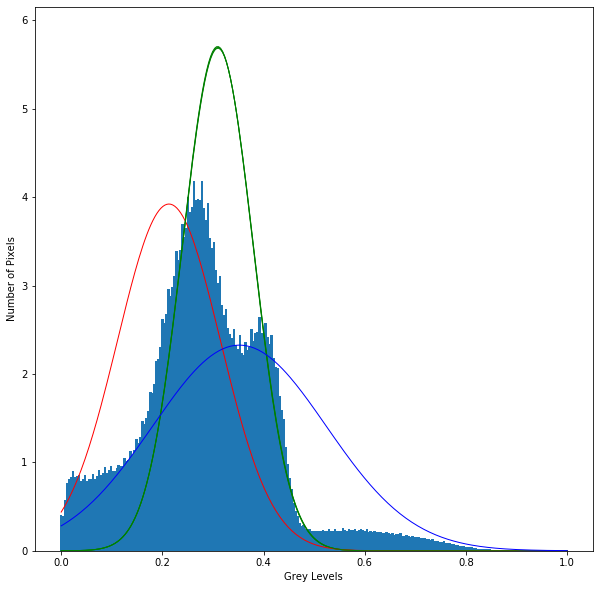

[0.21292767 0.30978604 0.35223192]
[0.10169701 0.07016233 0.17146708]


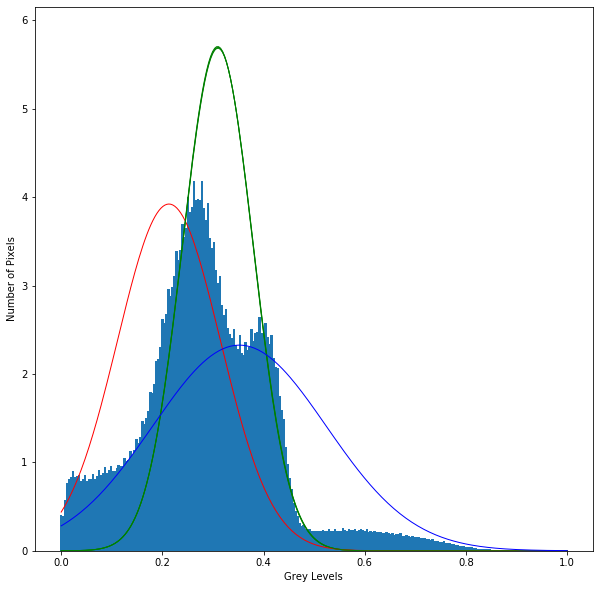

In [20]:
%matplotlib inline

class_prob, finalMeansArray, finalStdsArray,EMBrain = em(originalBrainImg,
                                                 ZeroBrainImg,
                                                initialMeansArray, 
                                                initialStdsArray, 
                                                priorProbabilities, 
                                                tol=1e-3, 
                                                max_iter=100)

print(finalMeansArray)
print(finalStdsArray)

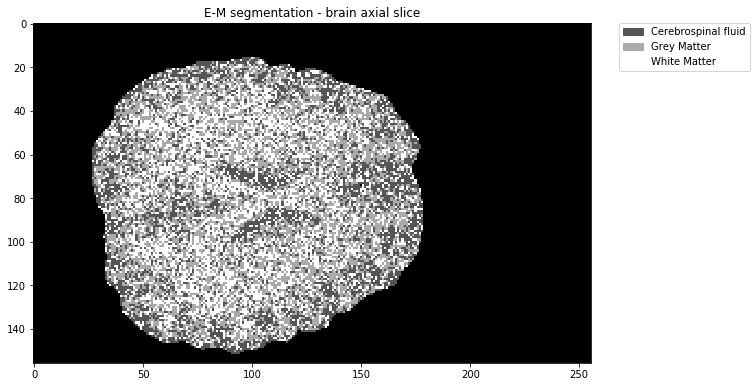

In [21]:
## Show EM segmentation results



values = np.unique(EMBrain.ravel())
values = values[1:]

plt.figure(figsize=(10,10))
im = plt.imshow(EMBrain[:,:,190],cmap=plt.cm.gray)

# get the colors of the values, according to the 
# colormap used by imshow

colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
labels = {0: 'Cerebrospinal fluid',1:'Grey Matter',2:'White Matter'}

patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title('E-M segmentation - brain axial slice')
plt.show()


As we observe, E-M algorithm gives very poor results. Observing the histogram, one can note the distributions of the different elements to segment do not follow a normal curve. In consequence, our algorithm can not provide correct results. By changing the nature of the distributions in our algorithm, we may obtain better results. However, thoses distributions could change for other brain images. As we are looking for the most automatic algorithm possible, we will not use this segmentation algorithm.

### K-means algorithm


K-means algorithm tries to divide the data in clusters by minimizing the dissimilarity between the points in the the same cluster. In our case, the clusters correspond to the different parts of the segmentation. Unlike precedent algorithms, we use here an existing Python method. Since the method needs to be applied on 1D image, we have reshaped our 3D image into 1 dimension. After the application of the segmentation algorithm, we reset the shape in 3D.

In [22]:
x,y,z = originalBrainImg.shape
brainReshape = originalBrainImg.reshape(x*y*z)
brainReshape= brainReshape.reshape(-1,1)

km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, max_iter=10000, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(brainReshape)
brainKmeans = y_km.reshape(x,y,z)

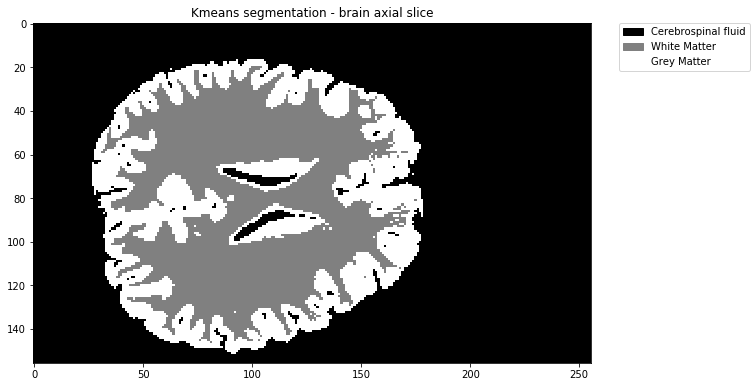

In [23]:
values = np.unique(brainKmeans.ravel())

plt.figure(figsize=(10,10))
im = plt.imshow(brainKmeans[:,:,190],cmap=plt.cm.gray)

# get the colors of the values, according to the 
# colormap used by imshow

colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
labels = {0: 'Cerebrospinal fluid',1:'White Matter',2:'Grey Matter'}

patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title('Kmeans segmentation - brain axial slice')
plt.show()

The segmentation results obtained here are very good. Compared to two other algorithms, the intensity of the voxels in the white and grey matter have been "inverted" but it has no impact on the result's quality. We have here an automatic algorithm able to segment with good precision the white matter, grey matter and cerebrospinal fluid on brain MR images. 

In order to have the best segmentation possible, we will now use morphological operators. It will remove the small holes we have currently in the kmeans segmentation.

### Morphological operators in order to smooth the segmentation

In [24]:
#Binary brain where white matter is set to 1 and the rest to 0
oneBrain = brainKmeans.copy()
for i in range(x):
    for j in range(y):
        for k in range(z):
            if oneBrain[i,j,k] == 2 :
                oneBrain[i,j,k] = 0

arr = oneBrain>0
remove1 = np.zeros((x,y,z))
for k in range(z):
    remove1[:,:,k] = remove_small_holes(arr[:,:,k],100)
    
brainKmeans2 = brainKmeans.copy()
for i in range(x):
    for j in range(y):
        for k in range(z):
            if remove1[i,j,k] == True :
                brainKmeans2[i,j,k] = 1
                
#Binary brain where grey matter is set to 1 and the rest to 0
twoBrain = brainKmeans2.copy()
for i in range(x):
    for j in range(y):
        for k in range(z):
            if twoBrain[i,j,k] == 1 :
                twoBrain[i,j,k] = 0
                
arr = twoBrain>0
remove2 = np.zeros((x,y,z))
for k in range(z):
    remove2[:,:,k] = remove_small_holes(arr[:,:,k],100)
    
brainKmeansfinal = brainKmeans2.copy()
for i in range(x):
    for j in range(y):
        for k in range(z):
            if remove2[i,j,k] == True :
                brainKmeansfinal[i,j,k] = 2
                


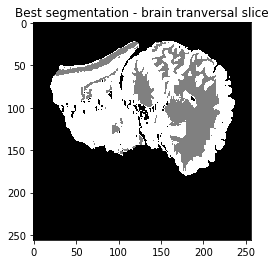

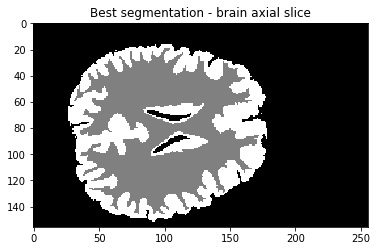

In [25]:
plt.imshow(brainKmeansfinal[100,:,:], cmap='gray')
plt.title('Best segmentation - brain tranversal slice')
plt.show()
plt.imshow(brainKmeansfinal[:,:,190], cmap='gray')
plt.title('Best segmentation - brain axial slice')
plt.show()

In [78]:
#We save the final segmentation as nifti file
#kmeans_seg = nib.Nifti1Image(brainKmeansfinal, affine=img_mask.affine)
#nib.save(kmeans_seg, 'Data/segmentationKmeans.nii')

We have now obtained a segmentation of good quality for our task. The process is totally automatized and needs no change to work on other brain MR images where the skull has been stripped. We can now work on our second segmentation task. 

## Corpus callosum segmentation



To compute the mask of the corpus callosum we will use the diffuse tensor imaging (DTI) which is based on anisotropic diffusion. This gives us 4 files: the mean diffusivity (MD), the radial diffusivity (RD), the axial diffusivity (AD) and the coloured fractional anisotropy (FA). <br>

The corpus callosum is the white matter that links the two hemisphere of the brain. This makes its fibers close to parallel with the sagital axis. 



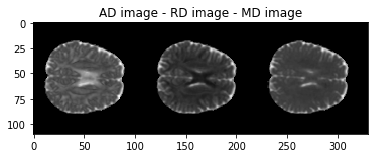

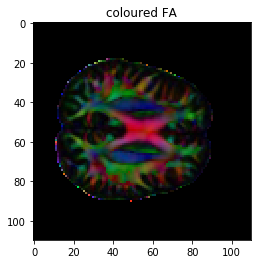

In [66]:
#Visualization of the 4 images
file_path = "Data/P1_color_fa.nii.gz"
cfa=nib.load(file_path)
cfa_data=cfa.get_fdata()
cfa_image = cfa_data[:,:,40]

file_path = "Data/P1_AD.nii.gz"
ad=nib.load(file_path)
ad_data=ad.get_fdata()
ad_image = ad_data[:,:,40]

file_path = "Data/P1_RD.nii.gz"
rd=nib.load(file_path)
rd_data=rd.get_fdata()
rd_image = rd_data[:,:,40]
#plt.imshow(cfa_img)

file_path = "Data/P1_MD.nii.gz"
md=nib.load(file_path)
md_data=md.get_fdata()
md_image = md_data[:,:,40]


clip = np.hstack((ad_image,rd_image, md_image))
plt.imshow(clip, cmap='gray')
plt.title('AD image - RD image - MD image')
plt.show()

plt.imshow(cfa_image)
plt.title("coloured FA")
plt.show()

As we can see in the images above, the CC appears in red in the coloured FA. We will thus work with the red part of the coloured FA image to compute the mask.

<font size= 4>1) Compute the red coloured FA mask </font><br>

To do so we start by computing the threshold as equal to 40% of the range of red value in the image<br>

We keep all the pixels with value greater than the threshold then apply 2 openings with first a 1 by 2 rectangle then by a 2 by 1 rectangle to eliminate noisy pixels. This will be the standard behaviour used during all this segmentation so we define the morph_operator function just below

In [67]:


def morph_operator(image):
    kernel = np.ones((1,2),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((2,1),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    
    return image


def remove_objects(image, size):
    image_labeled = image > 0
    mask = remove_small_objects(image_labeled, min_size=size)
    mask = np.where(mask, 1, 0)
    
    return mask


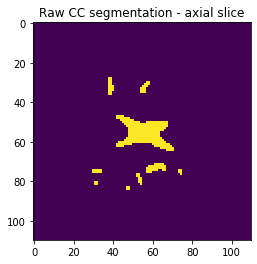

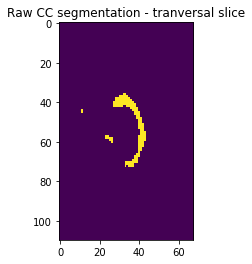

In [68]:
morpho = True

red_cfa_mask = np.zeros(cfa_data[:,:,:,0].shape)

#Threshold computation
min_val = cfa_data[:,:,:,0].min()
max_val = cfa_data[:,:,:,0].max()
threshold = (max_val - min_val) * 0.4

for i in range(cfa_data.shape[2]):
    #take the red colour
    img = cfa_data[:,:,i,0]
    
    #Apply threshold to cfa intensity
    thresh = np.where(img > threshold, 1, img/1.5 + 0.0001)
        
    if morpho:
        #Apply morphological operators
        thresh = morph_operator(thresh)
    red_cfa_mask[:,:,i] = thresh
    
red_cfa_mask = np.where(red_cfa_mask == 1, 1, 0)
 
plt.imshow(red_cfa_mask[:,:,40])
plt.title("Raw CC segmentation - axial slice")
plt.show()
plt.imshow(red_cfa_mask[50,:,:])
plt.title("Raw CC segmentation - tranversal slice")
plt.show()

<font size=4>2) Remove small artifacts</font> <br>

We see on the image above that we have a nice segmentation of the corpus callosum but so noisy pixels remain. To remove them we will use the remove_small_object function from the skimage library that remove object in a 3D images that are below a certain size of pixel.

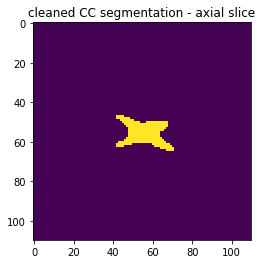

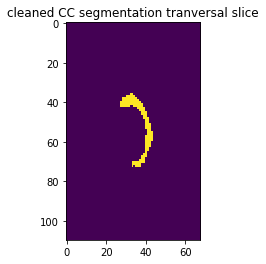

In [79]:
cc_mask = remove_objects(red_cfa_mask, 2000)

#uncomment the 2 next lines to save into a nifti image for 3D visualization
#clipped_img = nib.Nifti1Image(cc_mask, ad.affine, ad.header)
#nib.save(clipped_img, 'Data/cc_seg_cleaned_unmorph.nii')


plt.imshow(cc_mask[:,:,40])
plt.title("cleaned CC segmentation - axial slice")
plt.show()

plt.imshow(cc_mask[50,:,:])
plt.title("cleaned CC segmentation tranversal slice")
plt.show()

## Corticospinal tract segmentation


The corticospinal tract is made of fibers coming from the cerebral cortex and going down through the spinal cord. In the coloured FA, they are represented in blue due to their vertical direction (top-bottom axis). We then again decided to define our threshold to be equal to 40% of the range of blue in the image and to keep pixels above the threshold.

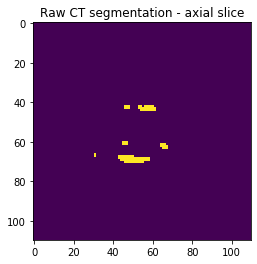

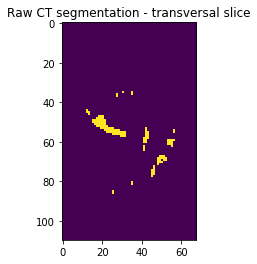

In [70]:
morpho = True

blue_cfa_mask = np.zeros(cfa_data[:,:,:,2].shape)

#Threshold computation
min_val = cfa_data[:,:,:,2].min()
max_val = cfa_data[:,:,:,2].max()
threshold = (max_val - min_val) * 0.4

for i in range(cfa_data.shape[2]):
    #take the blue colour
    img = cfa_data[:,:,i,2]
    
    #Apply threshold to cfa intensity
    thresh = np.where(img > threshold, 1, img/1.5 + 0.0001)
        
    if morpho:
        #Apply morphological operators
        thresh = morph_operator(thresh)
    blue_cfa_mask[:,:,i] = thresh

#Make the image binary
blue_cfa_mask = np.where(blue_cfa_mask == 1, 1, 0)
 
plt.imshow(blue_cfa_mask[:,:,40])
plt.title("Raw CT segmentation - axial slice")
plt.show()
plt.imshow(blue_cfa_mask[50,:,:])
plt.title("Raw CT segmentation - transversal slice")
plt.show()

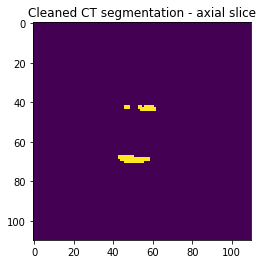

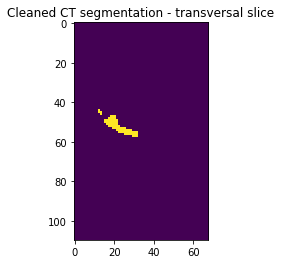

In [80]:
and_mask = (blue_cfa_mask - cc_mask).clip(min=0)

and_mask = remove_objects(and_mask, 2000)

#uncomment the 2 next lines to save into a nifti image for 3D visualization
#clipped_img = nib.Nifti1Image(and_mask, ad.affine, ad.header)
#nib.save(clipped_img, 'Data/bs_seg_cleaned.nii')

plt.imshow(and_mask[:,:,40])
plt.title("Cleaned CT segmentation - axial slice")
plt.show()
plt.imshow(and_mask[50,:,:])
plt.title("Cleaned CT segmentation - transversal slice")
plt.show()

## Refinement of CC and CT segmentation using white matter segmentation


Both the corpus callossum and the corticospinal tract lie in the white matter of the brain. Using our existing white matter segmentation, we can refine CC and CT segmentation by supressing the segmented part outside of the white matter. In order to do that we need to superpose the FA with our white matter segmentation. It has been made possible thanks to Nicolas Delinte who gave us a Python script dedicated to such task (superpose.py). The result of this superposition is the NIFTI file "MASK_to_diffSpace2.nii.gz".

In [72]:
file_path = "Data/MASK_to_diffSpace2.nii.gz"
brain_img=nib.load(file_path)
brain=brain_img.get_fdata()

In [73]:
(x,y,z) = brain.shape
brain_with_cc = brain.copy()
for i in range(x):
    for j in range(y):
        for k in range(z):
            if brain_with_cc[i,j,k] == 1 and cc_mask[i,j,k] == 1:
                brain_with_cc[i,j,k] = 3

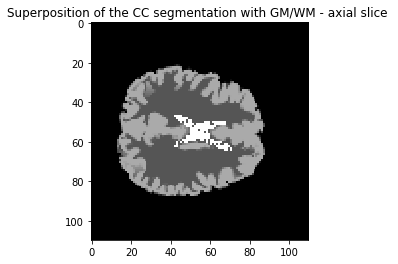

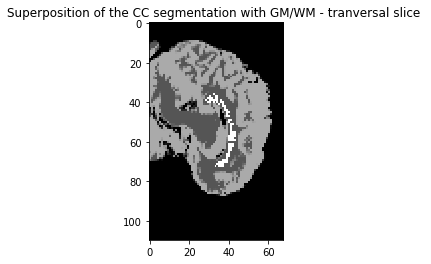

In [74]:

plt.imshow(brain_with_cc[:,:,40],cmap = 'gray')
plt.title('Superposition of the CC segmentation with GM/WM - axial slice ')
plt.show()
plt.imshow(brain_with_cc[50,:,:],cmap = 'gray')
plt.title('Superposition of the CC segmentation with GM/WM - tranversal slice ')
plt.show()

In [75]:
(x,y,z) = brain.shape
brain_with_and = brain.copy()
for i in range(x):
    for j in range(y):
        for k in range(z):
            if brain_with_and[i,j,k] == 1 and and_mask[i,j,k] == 1:
                brain_with_and[i,j,k] = 3

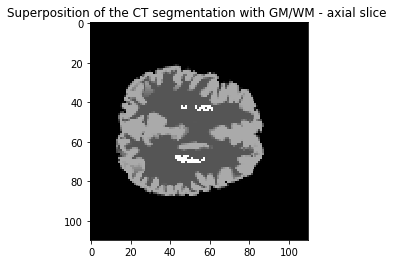

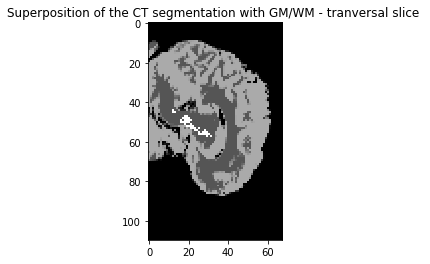

In [76]:

plt.imshow(brain_with_and[:,:,40],cmap = 'gray')
plt.title('Superposition of the CT segmentation with GM/WM - axial slice ')
plt.show()
plt.imshow(brain_with_and[50,:,:],cmap = 'gray')
plt.title('Superposition of the CT segmentation with GM/WM - tranversal slice ')
plt.show()

This last refinement do not seems to improve the segmentation. This step can be seen as a validation tool for our segmentation. The segmentations we obtained are of very good quality. Except a small outlier in the CT segmentation, there seems to be no error at all in both segmentations. It is now time to observe how our automatic algorithms adapt to the brain of an alcoholic patient.

## Segmentation on brain from alcoholic patient

Unfortunately, it is not possible to test our WM/GM + cerebrospinal fluid segmentation on this brain. Indeed the skullstripping gives bad results by keeping large part of the skull. In consequence, we do not have the mandatory MR image to compute our first segmentation. With skull on the image, the segmentation algorithm is completely disturb and can not produce good segmentation results.

Our test will focus on the CC and CT segmentation. Compared to classical brain, the segmentation should be more difficult. Indeed, on alcoholic patient, the CC reduce in size.

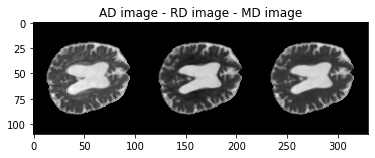

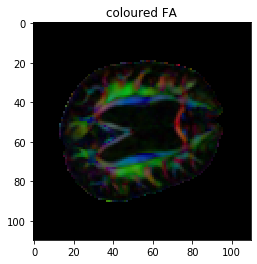

In [81]:
file_path = "Data/P2_color_fa.nii.gz"
cfa=nib.load(file_path)
cfa_data=cfa.get_fdata()
cfa_image = cfa_data[:,:,40]

file_path = "Data/P2_AD.nii.gz"
ad=nib.load(file_path)
ad_data=ad.get_fdata()
ad_image = ad_data[:,:,40]

file_path = "Data/P2_RD.nii.gz"
rd=nib.load(file_path)
rd_data=rd.get_fdata()
rd_image = rd_data[:,:,40]
#plt.imshow(cfa_img)

file_path = "Data/P2_MD.nii.gz"
md=nib.load(file_path)
md_data=md.get_fdata()
md_image = md_data[:,:,40]


clip = np.hstack((ad_image,rd_image, md_image))
plt.imshow(clip, cmap='gray')
plt.title('AD image - RD image - MD image')
plt.show()

plt.imshow(cfa_image)
plt.title("coloured FA")
plt.show()

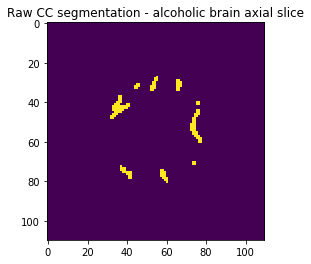

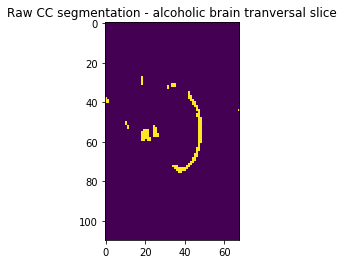

In [82]:
morpho = True

red_cfa_mask = np.zeros(cfa_data[:,:,:,0].shape)

#Threshold computation
min_val = cfa_data[:,:,:,0].min()
max_val = cfa_data[:,:,:,0].max()
threshold = (max_val - min_val) * 0.3

for i in range(cfa_data.shape[2]):
    #take the red colour
    img = cfa_data[:,:,i,0]
    
    #Apply threshold to cfa intensity
    thresh = np.where(img > threshold, 1, img/1.5 + 0.0001)
        
    if morpho:
        #Apply morphological operators
        thresh = morph_operator(thresh)
    red_cfa_mask[:,:,i] = thresh
    
red_cfa_mask = np.where(red_cfa_mask == 1, 1, 0)
 
plt.imshow(red_cfa_mask[:,:,40])
plt.title("Raw CC segmentation - alcoholic brain axial slice")
plt.show()
plt.imshow(red_cfa_mask[50,:,:])
plt.title("Raw CC segmentation - alcoholic brain tranversal slice")
plt.show()

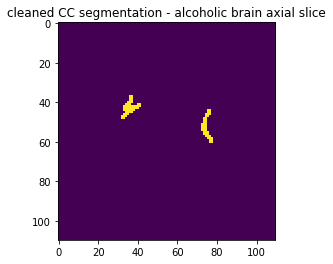

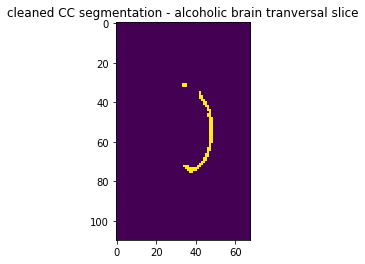

In [83]:
cc_mask = remove_objects(red_cfa_mask, 2000)

#uncomment the 2 next lines to save into a nifti image for 3D visualization
#clipped_img = nib.Nifti1Image(cc_mask, ad.affine, ad.header)
#nib.save(clipped_img, 'Data/cc_seg_cleaned_unmorph_alcoholic.nii')


plt.imshow(cc_mask[:,:,40])
plt.title("cleaned CC segmentation - alcoholic brain axial slice")
plt.show()

plt.imshow(cc_mask[50,:,:])
plt.title("cleaned CC segmentation - alcoholic brain tranversal slice")
plt.show()

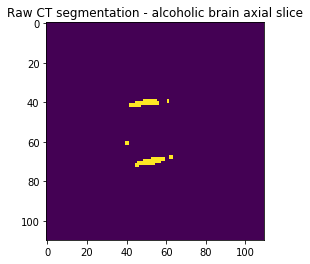

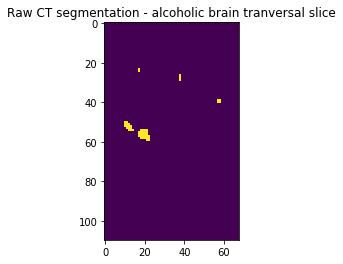

In [84]:
morpho = True

blue_cfa_mask = np.zeros(cfa_data[:,:,:,2].shape)

#Threshold computation
min_val = cfa_data[:,:,:,2].min()
max_val = cfa_data[:,:,:,2].max()
threshold = (max_val - min_val) * 0.4

for i in range(cfa_data.shape[2]):
    #take the blue colour
    img = cfa_data[:,:,i,2]
    
    #Apply threshold to cfa intensity
    thresh = np.where(img > threshold, 1, img/1.5 + 0.0001)
        
    if morpho:
        #Apply morphological operators
        thresh = morph_operator(thresh)
    blue_cfa_mask[:,:,i] = thresh
    
blue_cfa_mask = np.where(blue_cfa_mask == 1, 1, 0)
 
plt.imshow(blue_cfa_mask[:,:,40])
plt.title("Raw CT segmentation - alcoholic brain axial slice")
plt.show()
plt.imshow(blue_cfa_mask[50,:,:])
plt.title("Raw CT segmentation - alcoholic brain tranversal slice")
plt.show()

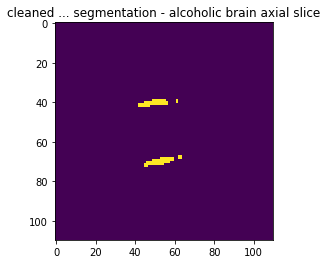

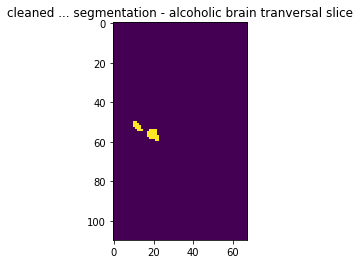

In [85]:

and_mask = (blue_cfa_mask - cc_mask).clip(min=0)

and_mask = remove_objects(and_mask, 2000)

#uncomment the 2 next lines to save into a nifti image for 3D visualization
#clipped_img = nib.Nifti1Image(and_mask, ad.affine, ad.header)
#nib.save(clipped_img, 'Data/bs_seg_cleaned_alcoholic.nii')

plt.imshow(and_mask[:,:,40])
plt.title("cleaned ... segmentation - alcoholic brain axial slice")
plt.show()

plt.imshow(and_mask[50,:,:])
plt.title("cleaned ... segmentation - alcoholic brain tranversal slice")
plt.show()

As expected the segmentation is way more complex, especially for the corpus callosum. Without adapting our treshold, it was impossible to segment the CC. By reducing the treshold to 30 %, we are able to segment correctly the CC. In consequence our segmentation is not totally automatic since we have to play with the treshold to obtain a correct segmentation. We were still able to obtain a good segmentation by adapting very slightly the treshold of the algorithm. Knowing the CC segmentation on alcoholic brain is very complex due to the small size of the CC, we can be satisfied of our result.

For the CT segmentation, as expected, it is less disturb by the alcoholism. Our original algorithm (without any changes) shows good results even on an alcoholic patient brain !